# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = '2kr.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## 2kr

In [9]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1.00000,1.00000,0.999110,1.000000,0.99911,1.00000,0.998221,0.994662,1.00000,1.000000,0.999110,0.000890,0.000890,-1.110223e-16,0.000890,-1.110223e-16,0.000890,-0.000890,-0.004448,0.000890,0.000890
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.00000,1.00000,0.999110,1.000000,0.99911,1.00000,1.000000,1.000000,1.00000,0.999110,0.999733,0.000267,0.000267,-6.227758e-04,0.000267,-6.227758e-04,0.000267,0.000267,0.000267,0.000267,-0.000623
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.00000,1.00000,1.000000,0.998221,1.00000,1.00000,1.000000,0.999110,1.00000,1.000000,0.999733,0.000267,0.000267,2.669039e-04,-0.001512,2.669039e-04,0.000267,0.000267,-0.000623,0.000267,0.000267
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.00000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.00000,0.99911,0.997331,0.997331,1.00000,0.99911,1.000000,1.000000,0.99911,1.000000,0.999199,0.000801,-0.000089,-1.868327e-03,-0.001868,8.007117e-04,-0.000089,0.000801,0.000801,-0.000089,0.000801
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1.00000,1.00000,0.999110,0.999110,1.00000,1.00000,0.999110,1.000000,1.00000,0.998221,0.999555,0.000445,0.000445,-4.448399e-04,-0.000445,4.448399e-04,0.000445,-0.000445,0.000445,0.000445,-0.001335
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.00000,1.00000,1.000000,1.000000,1.00000,0.99911,0.998221,1.000000,1.00000,0.999110,0.999644,0.000356,0.000356,3.558719e-04,0.000356,3.558719e-04,-0.000534,-0.001423,0.000356,0.000356,-0.000534
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.00000,1.00000,1.000000,1.000000,1.00000,0.99911,1.000000,1.000000,1.00000,1.000000,0.999911,0.000089,0.000089,8.896797e-05,0.000089,8.896797e-05,-0.000801,0.000089,0.000089,0.000089,0.000089
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.00000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.996619,0.002847,-0.000534,0.001601,0.001779,0.0,-0.001779,-0.001246,-0.000178,-0.0,-0.000356,0.0,0.000534,0.000534,0.000356,-0.000178,0.002489,0.002490,-0.002845,-0.001956,0.001601,-0.000179,-0.001067,-0.002844,0.002490,-0.000179
Mean (Qi),0.999789,0.000178,-0.000033,0.0001,0.000111,0.0,-0.000111,-0.000078,-0.000011,-0.0,-0.000022,0.0,0.000033,0.000033,0.000022,-0.000011,0.000156,0.000156,-0.000178,-0.000122,0.000100,-0.000011,-0.000067,-0.000178,0.000156,-0.000011
SSQ,,,,,,,,,,,,,,,,,0.000003,0.000001,0.000005,0.000007,0.000001,0.000003,0.000004,0.000021,0.000001,0.000004


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000005,0.0,0.000002,0.000002,0.0,0.000002,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00005
Variation,0.081038,0.002849,0.025641,0.031656,0.0,0.031656,0.015511,0.000317,0.0,0.001266,0.0,0.002849,0.002849,0.001266,0.000317,0.000063
Variation%,8.10%,0.28%,2.56%,3.17%,0.00%,3.17%,1.55%,0.03%,0.00%,0.13%,0.00%,0.28%,0.28%,0.13%,0.03%,80.28%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.00027,0.000059,0.000192,0.000203,0.000092,-0.000019,0.000014,0.000081,0.000092,0.00007,0.000092,0.000126,0.000126,0.000114,0.000081
CI- Qi (95.00%),0.000086,-0.000126,0.000008,0.000019,-0.000092,-0.000203,-0.00017,-0.000103,-0.000092,-0.000114,-0.000092,-0.000059,-0.000059,-0.00007,-0.000103
Distance (Qi),0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184
Zero Included,False,True,False,False,True,False,True,True,True,True,True,True,True,True,True
CI+ Variation,0.186843,0.008875,0.094685,0.105951,0.02178,0.00092,0.000531,0.016845,0.02178,0.012543,0.02178,0.040384,0.040384,0.03355,0.016845
CI- Variation,0.018794,0.040384,0.000157,0.00092,0.02178,0.105951,0.074052,0.027348,0.02178,0.03355,0.02178,0.008875,0.008875,0.012543,0.027348
CI Distance (Variation),0.168049,0.031509,0.094528,0.105031,0.0,0.105031,0.073522,0.010503,0.0,0.021006,0.0,0.031509,0.031509,0.021006,0.010503


SSE = 5.018300173503474e-05
SST = 6.251108141994044e-05
Error variance = 3.484930676044079e-07
Unexplained Variation = 80.28%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,789.0,615.0,753.0,809.0,663.0,775.0,862.0,662.0,673.0,740.0,734.1,54.9,-119.1,18.9,74.9,-71.1,40.9,127.9,-72.1,-61.1,5.9
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,475.0,544.0,491.0,404.0,448.0,468.0,508.0,403.0,405.0,459.0,460.5,14.5,83.5,30.5,-56.5,-12.5,7.5,47.5,-57.5,-55.5,-1.5
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,985.0,1017.0,951.0,1044.0,992.0,1042.0,1069.0,1010.0,993.0,989.0,1009.2,-24.2,7.8,-58.2,34.8,-17.2,32.8,59.8,0.8,-16.2,-20.2
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,702.0,760.0,727.0,661.0,672.0,664.0,742.0,656.0,588.0,649.0,682.1,19.9,77.9,44.9,-21.1,-10.1,-18.1,59.9,-26.1,-94.1,-33.1
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,736.0,725.0,691.0,571.0,684.0,742.0,696.0,606.0,742.0,667.0,686.0,50.0,39.0,5.0,-115.0,-2.0,56.0,10.0,-80.0,56.0,-19.0
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,421.0,495.0,425.0,375.0,437.0,415.0,337.0,500.0,448.0,498.0,435.1,-14.1,59.9,-10.1,-60.1,1.9,-20.1,-98.1,64.9,12.9,62.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,977.0,1013.0,1070.0,910.0,980.0,1016.0,966.0,889.0,991.0,994.0,980.6,-3.6,32.4,89.4,-70.6,-0.6,35.4,-14.6,-91.6,10.4,13.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,667.0,639.0,710.0,617.0,626.0,569.0,602.0,582.0,657.0,586.0,625.5,41.5,13.5,84.5,-8.5,0.5,-56.5,-23.5,-43.5,31.5,-39.5
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3460.0,3963.0,3382.0,3186.0,3856.0,3444.0,3352.0,3411.0,3031.0,3522.0,3460.7,-0.7,502.3,-78.7,-274.7,395.3,-16.7,-108.7,-49.7,-429.7,61.3


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,34712.4,23486.2,-1611.8,9731.4,-6328.8,-1294.4,7768.0,-3915.4,-108.8,-312.2,340.2,-85.4,-301.6,655.6,-717.6,-616.2,-349340.66000,3354013.040,-2.376243e+06,-2.970970e+06,-1.176447e+06,-457353.1600,1096095.440,3.434845e+06,-523857.9600,-30740.96
Mean (Qi),2169.525,1467.8875,-100.7375,608.2125,-395.55,-80.9,485.5,-244.7125,-6.8,-19.5125,21.2625,-5.3375,-18.85,40.975,-44.85,-38.5125,-21833.79125,209625.815,-1.485152e+05,-1.856856e+05,-7.352795e+04,-28584.5725,68505.965,2.146778e+05,-32741.1225,-1921.31
SSQ,,,,,,,,,,,,,,,,,592016.26000,423172.860,3.636361e+05,3.741087e+05,6.045703e+05,253412.2600,457872.060,3.795353e+05,352744.8600,153488.86


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,344750994.025,1623687.025,59187591.225,25033568.4,1047169.6,37713640.0,9581473.225,7398.4,60918.025,72335.025,4558.225,56851.6,268632.1,321843.6,237314.025,3954557.4
Variation,0.712409,0.003355,0.122308,0.051731,0.002164,0.077933,0.0198,0.000015,0.000126,0.000149,0.000009,0.000117,0.000555,0.000665,0.00049,483922531.9
Variation%,71.24%,0.34%,12.23%,5.17%,0.22%,7.79%,1.98%,0.00%,0.01%,0.01%,0.00%,0.01%,0.06%,0.07%,0.05%,0.82%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),1493.782804,-74.842196,634.107804,-369.654696,-55.004696,511.395304,-218.817196,19.095304,6.382804,47.157804,20.557804,7.045304,66.870304,-18.954696,-12.617196
CI- Qi (95.00%),1441.992196,-126.632804,582.317196,-421.445304,-106.795304,459.604696,-270.607804,-32.695304,-45.407804,-4.632804,-31.232804,-44.745304,15.079696,-70.745304,-64.407804
Distance (Qi),51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608
Zero Included,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False
CI+ Variation,0.737767,0.001852,0.132944,0.045179,0.001,0.086468,0.015831,0.000121,0.000013,0.000735,0.00014,0.000016,0.001478,0.000119,0.000053
CI- Variation,0.687496,0.005302,0.112115,0.058725,0.003771,0.069841,0.024212,0.000353,0.000682,0.000007,0.000323,0.000662,0.000075,0.001655,0.001372
CI Distance (Variation),0.050271,0.00345,0.02083,0.013546,0.002771,0.016627,0.008381,0.000233,0.000668,0.000728,0.000183,0.000646,0.001403,0.001536,0.001319


SSE = 3954557.3999999994
SST = 483922531.89999986
Error variance = 27462.204166666663
Unexplained Variation = 0.82%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,870.0,881.0,892.0,900.0,875.0,899.0,909.0,860.0,893.0,884.0,886.3,-16.3,-5.3,5.7,13.7,-11.3,12.7,22.7,-26.3,6.7,-2.3
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,835.0,865.0,844.0,832.0,836.0,830.0,845.0,838.0,830.0,840.0,839.5,-4.5,25.5,4.5,-7.5,-3.5,-9.5,5.5,-1.5,-9.5,0.5
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1124.0,1123.0,1123.0,1122.0,1122.0,1122.0,1123.0,1122.0,1121.0,1123.0,1122.5,1.5,0.5,0.5,-0.5,-0.5,-0.5,0.5,-0.5,-1.5,0.5
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1124.0,1121.0,1124.0,1120.0,1121.0,1123.0,1122.0,1124.0,1119.0,1122.0,1122.0,2.0,-1.0,2.0,-2.0,-1.0,1.0,0.0,2.0,-3.0,0.0
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,858.0,894.0,878.0,832.0,877.0,863.0,873.0,851.0,883.0,887.0,869.6,-11.6,24.4,8.4,-37.6,7.4,-6.6,3.4,-18.6,13.4,17.4
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,824.0,816.0,812.0,781.0,801.0,801.0,776.0,807.0,798.0,809.0,802.5,21.5,13.5,9.5,-21.5,-1.5,-1.5,-26.5,4.5,-4.5,6.5
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1121.0,1119.0,1119.0,1117.0,1120.0,1113.0,1109.0,1120.0,1123.0,1117.0,1117.8,3.2,1.2,1.2,-0.8,2.2,-4.8,-8.8,2.2,5.2,-0.8
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1104.0,1098.0,1104.0,1102.0,1096.0,1094.0,1102.0,1103.0,1106.0,1097.0,1100.6,3.4,-2.6,3.4,1.4,-4.6,-6.6,1.4,2.4,5.4,-3.6
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,700.0,725.0,639.0,633.0,723.0,678.0,688.0,688.0,623.0,693.0,679.0,21.0,46.0,-40.0,-46.0,44.0,-1.0,9.0,9.0,-56.0,14.0


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,14309.3,-1412.3,-468.7,2998.3,-677.7,-309.1,868.3,-414.5,-116.9,-230.5,244.9,-172.1,-156.5,52.5,-167.5,-174.7,89026.830000,20450.530000,-56720.870000,-110584.870000,-83488.670000,49031.130000,41216.530000,60780.630000,-43934.070000,34222.830000
Mean (Qi),894.33125,-88.26875,-29.29375,187.39375,-42.35625,-19.31875,54.26875,-25.90625,-7.30625,-14.40625,15.30625,-10.75625,-9.78125,3.28125,-10.46875,-10.91875,5564.176875,1278.158125,-3545.054375,-6911.554375,-5218.041875,3064.445625,2576.033125,3798.789375,-2745.879375,2138.926875
SSQ,,,,,,,,,,,,,,,,,8398.170000,7140.770000,4912.570000,8248.570000,11595.170000,4025.570000,7000.770000,12654.570000,8581.970000,4795.170000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,1246619.55625,137299.80625,5618626.80625,287048.30625,59714.25625,471215.55625,107381.40625,8541.00625,33206.40625,37485.00625,18511.50625,15307.65625,1722.65625,17535.15625,19075.05625,77353.3
Variation,0.152835,0.016833,0.688841,0.035192,0.007321,0.057771,0.013165,0.001047,0.004071,0.004596,0.00227,0.001877,0.000211,0.00215,0.002339,8156643.44375
Variation%,15.28%,1.68%,68.88%,3.52%,0.73%,5.78%,1.32%,0.10%,0.41%,0.46%,0.23%,0.19%,0.02%,0.21%,0.23%,0.95%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-84.647058,-25.672058,191.015442,-38.734558,-15.697058,57.890442,-22.284558,-3.684558,-10.784558,18.927942,-7.134558,-6.159558,6.902942,-6.847058,-7.297058
CI- Qi (95.00%),-91.890442,-32.915442,183.772058,-45.977942,-22.940442,50.647058,-29.527942,-10.927942,-18.027942,11.684558,-14.377942,-13.402942,-0.340442,-14.090442,-14.540442
Distance (Qi),7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384
Zero Included,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
CI+ Variation,0.14055,0.012928,0.715724,0.029431,0.004833,0.065739,0.009741,0.000266,0.002281,0.007028,0.000998,0.000744,0.000935,0.00092,0.001044
CI- Variation,0.165634,0.021252,0.662472,0.041467,0.010323,0.050317,0.017103,0.002343,0.006375,0.002678,0.004055,0.003524,0.000002,0.003895,0.004147
CI Distance (Variation),0.025083,0.008324,0.053252,0.012036,0.00549,0.015422,0.007362,0.002076,0.004094,0.00435,0.003057,0.00278,0.000932,0.002975,0.003103


SSE = 77353.3
SST = 8156643.44375
Error variance = 537.1756944444445
Unexplained Variation = 0.95%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.369448,4.174387,4.174387,4.276666,4.158883,4.356709,4.356709,4.143135,4.465908,4.682131,4.315836,0.053612,-0.141449,-0.141449,-0.039170,-0.156953,0.040872,0.040872,-0.172702,0.150072,0.366295
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.488636,4.553877,4.454347,4.219508,4.997212,4.653960,4.584967,4.736198,4.204693,4.682131,4.557553,-0.068917,-0.003676,-0.103206,-0.338045,0.439659,0.096407,0.027414,0.178645,-0.352860,0.124578
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.564348,4.418841,4.343805,4.094345,4.997212,4.736198,4.043051,4.672829,4.634729,4.595120,4.510048,0.054300,-0.091207,-0.166242,-0.415703,0.487164,0.226151,-0.466997,0.162781,0.124681,0.085072
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.584967,4.454347,4.110874,4.442651,4.644391,4.189655,4.836282,4.382027,4.219508,4.521789,4.438649,0.146318,0.015698,-0.327775,0.004002,0.205742,-0.248994,0.397633,-0.056622,-0.219141,0.083140
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.962845,4.890349,4.718499,4.727388,4.882802,5.030438,5.036953,4.718499,4.718499,4.709530,4.839580,0.123265,0.050769,-0.121081,-0.112192,0.043222,0.190858,0.197373,-0.121081,-0.121081,-0.130050
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.141664,4.762174,4.976734,5.379897,4.828314,4.605170,4.934474,4.804021,4.882802,5.283204,4.959845,0.181818,-0.197671,0.016888,0.420052,-0.131532,-0.354675,-0.025371,-0.155824,-0.077043,0.323358
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.934474,4.700480,4.727388,4.787492,4.718499,5.214936,5.313206,4.736198,4.727388,4.905275,4.876534,0.057940,-0.176053,-0.149146,-0.089042,-0.158035,0.338402,0.436672,-0.140335,-0.149146,0.028741
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.948760,4.990433,5.159055,4.624973,5.476464,4.787492,4.779123,5.273000,4.812184,4.828314,4.967980,-0.019220,0.022453,0.191076,-0.343007,0.508484,-0.180488,-0.188856,0.305020,-0.155795,-0.139666
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.258097,3.135494,3.258097,3.761200,3.178054,3.891820,3.367296,3.526361,3.465736,3.178054,3.402021,-0.143924,-0.266527,-0.143924,0.359179,-0.223967,0.489800,-0.034725,0.124340,0.063715,-0.223967


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,66.870048,-8.062002,4.074456,0.037488,0.719689,0.430751,-0.203303,-0.04437,0.025613,0.051642,-0.157777,0.086052,-0.031145,0.526092,0.215037,-0.353556,-2.496864,-2.132014,-3.256340,1.236823,6.372525,2.120631,4.056027,-0.608423,-3.957637,-1.334727
Mean (Qi),4.179378,-0.503875,0.254654,0.002343,0.044981,0.026922,-0.012706,-0.002773,0.001601,0.003228,-0.009861,0.005378,-0.001947,0.032881,0.01344,-0.022097,-0.156054,-0.133251,-0.203521,0.077301,0.398283,0.132539,0.253502,-0.038026,-0.247352,-0.083420
SSQ,,,,,,,,,,,,,,,,,0.373013,0.380080,0.582718,1.450448,1.159210,1.080247,1.025636,0.507774,0.592529,0.570823


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,40.622419,10.375746,0.000878,0.32372,0.115967,0.025833,0.00123,0.00041,0.001667,0.015559,0.004628,0.000606,0.172983,0.0289,0.078126,7.722476
Variation,0.682831,0.174408,0.000015,0.005441,0.001949,0.000434,0.000021,0.000007,0.000028,0.000262,0.000078,0.00001,0.002908,0.000486,0.001313,59.491148
Variation%,68.28%,17.44%,0.00%,0.54%,0.19%,0.04%,0.00%,0.00%,0.00%,0.03%,0.01%,0.00%,0.29%,0.05%,0.13%,12.98%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.467688,0.29084,0.03853,0.081167,0.063109,0.02348,0.033414,0.037788,0.039414,0.026326,0.041565,0.03424,0.069068,0.049627,0.01409
CI- Qi (95.00%),-0.540062,0.218467,-0.033844,0.008794,-0.009265,-0.048893,-0.03896,-0.034586,-0.032959,-0.046048,-0.030809,-0.038133,-0.003306,-0.022747,-0.058284
Distance (Qi),0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374,0.072374
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.588275,0.227498,0.003993,0.017719,0.010711,0.001483,0.003003,0.00384,0.004178,0.001864,0.004646,0.003153,0.01283,0.006624,0.000534
CI- Variation,0.784431,0.128362,0.003081,0.000208,0.000231,0.006429,0.004082,0.003217,0.002922,0.005703,0.002553,0.003911,0.000029,0.001392,0.009136
CI Distance (Variation),0.196156,0.099135,0.000912,0.017511,0.010481,0.004947,0.00108,0.000623,0.001257,0.003839,0.002094,0.000758,0.0128,0.005232,0.008602


SSE = 7.7224764241766675
SST = 59.49114812150207
Error variance = 0.05362830850122686
Unexplained Variation = 12.98%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.852030,4.700480,4.634729,4.787492,4.700480,4.804021,4.795791,4.488636,4.882802,5.075174,4.772164,0.079867,-0.071683,-0.137435,0.015328,-0.071683,0.031858,0.023627,-0.283527,0.110638,0.303010
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.905275,5.056246,4.919981,4.663439,5.342334,5.093750,5.017280,5.159055,4.770685,5.081404,5.000945,-0.095670,0.055301,-0.080964,-0.337506,0.341389,0.092805,0.016335,0.158110,-0.230260,0.080459
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.990433,4.890349,4.867534,4.488636,5.267858,5.129899,4.634729,5.093750,5.036953,5.030438,4.943058,0.047375,-0.052709,-0.075523,-0.454422,0.324800,0.186841,-0.308329,0.150692,0.093895,0.087380
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.056246,4.969813,4.595120,4.890349,5.003946,4.682131,5.236442,4.836282,4.595120,5.010635,4.887608,0.168637,0.082205,-0.292489,0.002741,0.116338,-0.205477,0.348833,-0.051327,-0.292489,0.123027
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.446737,5.327876,5.181784,5.192957,5.342334,5.505332,5.529429,5.247024,5.192957,5.075174,5.304160,0.142577,0.023716,-0.122377,-0.111204,0.038174,0.201171,0.225269,-0.057136,-0.111204,-0.228987
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.609472,5.111988,5.545177,5.771441,5.337538,5.181784,5.347108,5.214936,5.379897,5.717028,5.421637,0.187835,-0.309649,0.123541,0.349804,-0.084099,-0.239853,-0.074529,-0.206701,-0.041739,0.295391
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.424950,5.093750,5.176150,5.365976,5.123964,5.655992,5.686975,5.337538,5.075174,5.231109,5.317158,0.107792,-0.223408,-0.141008,0.048818,-0.193194,0.338834,0.369818,0.020380,-0.241984,-0.086049
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.472271,5.509388,5.541264,5.075174,5.828946,5.262690,5.262690,5.669881,5.356586,5.342334,5.432122,0.040148,0.077266,0.109141,-0.356949,0.396823,-0.169432,-0.169432,0.237759,-0.075536,-0.089788
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.871201,3.583519,3.688879,4.158883,3.555348,4.262680,3.891820,3.951244,3.871201,3.806662,3.864144,0.007057,-0.280625,-0.175264,0.294739,-0.308796,0.398536,0.027677,0.087100,0.007057,-0.057481


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,74.371454,-7.78625,4.10968,0.08566,0.682412,0.367075,-0.076421,-0.129134,0.060877,0.017018,-0.170361,0.129027,-0.1012,0.403124,0.310777,-0.252661,-1.719946,-1.089738,-3.145221,0.731829,4.982026,2.271560,5.617403,-0.318260,-4.752870,-2.576782
Mean (Qi),4.648216,-0.486641,0.256855,0.005354,0.042651,0.022942,-0.004776,-0.008071,0.003805,0.001064,-0.010648,0.008064,-0.006325,0.025195,0.019424,-0.015791,-0.107497,-0.068109,-0.196576,0.045739,0.311377,0.141972,0.351088,-0.019891,-0.297054,-0.161049
SSQ,,,,,,,,,,,,,,,,,0.504416,0.369378,0.625707,1.188824,0.865053,0.923137,0.725141,0.507891,0.523541,0.593398


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,37.89106,10.555917,0.004586,0.291054,0.084215,0.00365,0.010422,0.002316,0.000181,0.018139,0.010405,0.006401,0.101568,0.060364,0.039898,6.826486
Variation,0.677756,0.188813,0.000082,0.005206,0.001506,0.000065,0.000186,0.000041,0.000003,0.000324,0.000186,0.000114,0.001817,0.00108,0.000714,55.906664
Variation%,67.78%,18.88%,0.01%,0.52%,0.15%,0.01%,0.02%,0.00%,0.00%,0.03%,0.02%,0.01%,0.18%,0.11%,0.07%,12.21%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.452618,0.290878,0.039377,0.076674,0.056965,0.029247,0.025952,0.037828,0.035087,0.023375,0.042087,0.027698,0.059218,0.053446,0.018232
CI- Qi (95.00%),-0.520664,0.222832,-0.028669,0.008628,-0.011081,-0.038799,-0.042094,-0.030218,-0.032959,-0.04467,-0.025959,-0.040348,-0.008828,-0.014599,-0.049814
Distance (Qi),0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046,0.068046
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.5863,0.242146,0.004437,0.016825,0.009287,0.002448,0.001928,0.004095,0.003523,0.001564,0.005069,0.002196,0.010036,0.008175,0.000951
CI- Variation,0.775837,0.142106,0.002352,0.000213,0.000351,0.004308,0.005071,0.002613,0.003109,0.005711,0.001929,0.004659,0.000223,0.00061,0.007102
CI Distance (Variation),0.189538,0.10004,0.002085,0.016612,0.008936,0.00186,0.003143,0.001482,0.000414,0.004147,0.003141,0.002463,0.009813,0.007565,0.00615


SSE = 6.826486431027268
SST = 55.906663724719735
Error variance = 0.047406155771022696
Unexplained Variation = 12.21%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.187386,4.990433,5.023881,5.068904,5.036953,5.111988,5.147494,4.744932,5.209486,5.293305,5.081476,0.105910,-0.091044,-0.057596,-0.012572,-0.044524,0.030512,0.066018,-0.336544,0.128010,0.211829
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.283204,5.384495,5.176150,4.948760,5.556828,5.327876,5.273000,5.438079,5.068904,5.370638,5.282793,0.000410,0.101702,-0.106644,-0.334033,0.274035,0.045083,-0.009794,0.155286,-0.213889,0.087845
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.241747,5.181784,5.153292,4.691348,5.438079,5.365976,4.969813,5.332719,5.293305,5.303305,5.197137,0.044610,-0.015353,-0.043845,-0.505789,0.240943,0.168839,-0.227323,0.135582,0.096168,0.106168
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.370638,5.273000,4.969813,5.225747,5.327876,5.010635,5.446737,5.176150,4.890349,5.293305,5.198425,0.172213,0.074575,-0.228612,0.027322,0.129451,-0.187790,0.248312,-0.022275,-0.308076,0.094880
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.743003,5.602119,5.509388,5.541264,5.666427,5.805135,5.828946,5.598422,5.517453,5.318120,5.613028,0.129976,-0.010909,-0.103639,-0.071764,0.053399,0.192107,0.215918,-0.014606,-0.095575,-0.294908
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.866468,5.438079,5.834811,5.961005,5.686975,5.541264,5.700444,5.537334,5.676754,5.983936,5.722707,0.143761,-0.284628,0.112104,0.238298,-0.035732,-0.181443,-0.022263,-0.185373,-0.045953,0.261229
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.717028,5.407172,5.451038,5.686975,5.389072,5.863631,5.948035,5.673323,5.332719,5.529429,5.599842,0.117185,-0.192670,-0.148804,0.087133,-0.210771,0.263789,0.348193,0.073481,-0.267123,-0.070413
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.802118,5.786897,5.888878,5.298317,6.021023,5.662960,5.624018,5.955837,5.638355,5.631212,5.730962,0.071157,0.055936,0.157916,-0.432644,0.290062,-0.068001,-0.106944,0.224876,-0.092607,-0.099750
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.248495,3.871201,4.110874,4.406719,3.912023,4.510860,4.234107,4.304065,4.262680,4.127134,4.198816,0.049679,-0.327615,-0.087942,0.207903,-0.286793,0.312044,0.035291,0.105249,0.063864,-0.071681


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,79.283175,-7.569564,4.156791,-0.061404,0.712485,0.343376,-0.114127,-0.174323,0.098968,0.037654,-0.124694,0.171414,-0.038732,0.232484,0.244895,-0.198043,-1.545689,-0.647841,-1.491283,-1.785307,4.366049,2.010323,6.084840,-0.082314,-4.912501,-1.996276
Mean (Qi),4.955198,-0.473098,0.259799,-0.003838,0.04453,0.021461,-0.007133,-0.010895,0.006185,0.002353,-0.007793,0.010713,-0.002421,0.01453,0.015306,-0.012378,-0.096606,-0.040490,-0.093205,-0.111582,0.272878,0.125645,0.380302,-0.005145,-0.307031,-0.124767
SSQ,,,,,,,,,,,,,,,,,0.507489,0.365771,0.469034,1.019340,0.671030,0.629967,0.461960,0.467325,0.498894,0.486812


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,35.811439,10.799319,0.002357,0.317272,0.073692,0.008141,0.018993,0.006122,0.000886,0.009718,0.018364,0.000938,0.03378,0.037484,0.024513,5.57762
Variation,0.67901,0.204763,0.000045,0.006016,0.001397,0.000154,0.00036,0.000116,0.000017,0.000184,0.000348,0.000018,0.000641,0.000711,0.000465,52.740637
Variation%,67.90%,20.48%,0.00%,0.60%,0.14%,0.02%,0.04%,0.01%,0.00%,0.02%,0.03%,0.00%,0.06%,0.07%,0.05%,10.58%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.442344,0.290553,0.026916,0.075284,0.052215,0.023621,0.019858,0.036939,0.033107,0.02296,0.041467,0.028333,0.045284,0.04606,0.018376
CI- Qi (95.00%),-0.503851,0.229046,-0.034591,0.013777,-0.009293,-0.037887,-0.041649,-0.024568,-0.0284,-0.038547,-0.02004,-0.033174,-0.016223,-0.015448,-0.043131
Distance (Qi),0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507,0.061507
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.593602,0.256109,0.002198,0.017194,0.008271,0.001693,0.001196,0.004139,0.003325,0.001599,0.005217,0.002435,0.006221,0.006436,0.001024
CI- Variation,0.770158,0.159155,0.00363,0.000576,0.000262,0.004355,0.005262,0.001831,0.002447,0.004508,0.001218,0.003339,0.000798,0.000724,0.005644
CI Distance (Variation),0.176556,0.096955,0.001432,0.016618,0.008009,0.002662,0.004066,0.002308,0.000878,0.002908,0.003998,0.000903,0.005423,0.005712,0.004619


SSE = 5.577620276383951
SST = 52.74063695011328
Error variance = 0.038733474141555216
Unexplained Variation = 10.58%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.347108,5.164786,5.225747,5.220356,5.181784,5.303305,5.303305,4.919981,5.389072,5.411646,5.246709,0.100399,-0.081923,-0.020962,-0.026353,-0.064925,0.056596,0.056596,-0.326728,0.142363,0.164937
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.446737,5.549076,5.384495,5.164786,5.666427,5.451038,5.438079,5.564520,5.231109,5.529429,5.442570,0.004168,0.106506,-0.058075,-0.277784,0.223857,0.008469,-0.004490,0.121951,-0.211461,0.086859
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.379897,5.347108,5.313206,4.844187,5.537334,5.493061,5.141664,5.463832,5.429346,5.424950,5.337458,0.042439,0.009649,-0.024252,-0.493271,0.199876,0.155603,-0.195795,0.126373,0.091887,0.087492
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.497168,5.407172,5.147494,5.407172,5.468060,5.181784,5.552960,5.356586,5.017280,5.455321,5.349100,0.148069,0.058072,-0.201605,0.058072,0.118960,-0.167316,0.203860,0.007487,-0.331820,0.106221
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.908083,5.796058,5.673323,5.707110,5.820083,5.978886,5.998937,5.746203,5.690359,5.501258,5.782030,0.126053,0.014028,-0.108707,-0.074920,0.038053,0.196856,0.216907,-0.035827,-0.091671,-0.280772
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,6.018593,5.638355,5.963579,6.100319,5.837730,5.700444,5.891644,5.707110,5.843544,6.135565,5.883688,0.134905,-0.245334,0.079891,0.216631,-0.045958,-0.183245,0.007956,-0.176578,-0.040144,0.251876
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.921578,5.568345,5.616771,5.843544,5.583496,6.011267,6.040255,5.771441,5.488938,5.686975,5.753261,0.168317,-0.184917,-0.136490,0.090283,-0.169765,0.258006,0.286994,0.018180,-0.264323,-0.066286
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.981414,5.942799,6.023448,5.476464,6.142037,5.831882,5.814131,6.086775,5.834811,5.852202,5.898596,0.082818,0.044203,0.124851,-0.422133,0.243441,-0.066714,-0.084466,0.188178,-0.063786,-0.046394
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.418841,4.077537,4.290459,4.595120,4.127134,4.682131,4.418841,4.477337,4.442651,4.290459,4.382051,0.036790,-0.304514,-0.091592,0.213069,-0.254917,0.300080,0.036790,0.095286,0.060600,-0.091592


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,81.94945,-7.437375,4.119866,-0.11461,0.726692,0.236388,-0.081447,-0.182299,0.139966,0.040359,-0.110711,0.162247,-0.038624,0.170374,0.257036,-0.198757,-0.640450,-0.075735,-1.482531,-1.856331,2.843398,1.589026,6.365642,-1.045588,-4.374646,-1.322785
Mean (Qi),5.121841,-0.464836,0.257492,-0.007163,0.045418,0.014774,-0.00509,-0.011394,0.008748,0.002522,-0.006919,0.01014,-0.002414,0.010648,0.016065,-0.012422,-0.040028,-0.004733,-0.092658,-0.116021,0.177712,0.099314,0.397853,-0.065349,-0.273415,-0.082674
SSQ,,,,,,,,,,,,,,,,,0.441262,0.313092,0.332893,0.972826,0.622675,0.604844,0.374725,0.483630,0.433891,0.379551


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,34.571588,10.608311,0.00821,0.330051,0.034925,0.004146,0.020771,0.012244,0.001018,0.007661,0.016453,0.000932,0.018142,0.041292,0.02469,4.959389
Variation,0.682426,0.209403,0.000162,0.006515,0.000689,0.000082,0.00041,0.000242,0.00002,0.000151,0.000325,0.000018,0.000358,0.000815,0.000487,50.659822
Variation%,68.24%,20.94%,0.02%,0.65%,0.07%,0.01%,0.04%,0.02%,0.00%,0.02%,0.03%,0.00%,0.04%,0.08%,0.05%,9.79%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.435837,0.286491,0.021836,0.074417,0.043773,0.023909,0.017605,0.037747,0.031522,0.02208,0.03914,0.026585,0.039648,0.045064,0.016577
CI- Qi (95.00%),-0.493835,0.228492,-0.036162,0.016419,-0.014225,-0.03409,-0.040393,-0.020251,-0.026477,-0.035919,-0.018859,-0.031413,-0.018351,-0.012934,-0.041422
Distance (Qi),0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998,0.057998
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.599935,0.259226,0.001506,0.017491,0.006052,0.001805,0.000979,0.0045,0.003138,0.00154,0.004838,0.002232,0.004965,0.006414,0.000868
CI- Variation,0.77023,0.164892,0.00413,0.000851,0.000639,0.00367,0.005153,0.001295,0.002214,0.004075,0.001123,0.003117,0.001064,0.000528,0.005419
CI Distance (Variation),0.170295,0.094333,0.002624,0.016639,0.005413,0.001865,0.004174,0.003205,0.000924,0.002535,0.003715,0.000884,0.003901,0.005885,0.004551


SSE = 4.959389376875165
SST = 50.65982171971241
Error variance = 0.03444020400607753
Unexplained Variation = 9.79%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.407172,5.236442,5.327876,5.283204,5.262690,5.379897,5.361292,5.003946,5.442418,5.488938,5.319388,0.087784,-0.082946,0.008489,-0.036184,-0.056697,0.060510,0.041905,-0.315441,0.123030,0.169550
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.488938,5.598422,5.446737,5.257495,5.726848,5.525453,5.541264,5.613128,5.351858,5.579730,5.512987,-0.024050,0.085435,-0.066250,-0.255492,0.213860,0.012466,0.028276,0.100141,-0.161129,0.066743
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.463832,5.429346,5.407172,4.897840,5.641907,5.552960,5.220356,5.513429,5.517453,5.476464,5.412076,0.051756,0.017270,-0.004904,-0.514236,0.229831,0.140884,-0.191720,0.101353,0.105377,0.064388
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.560682,5.476464,5.198497,5.480639,5.533389,5.257495,5.627621,5.411646,5.081404,5.517453,5.414529,0.146153,0.061935,-0.216032,0.066110,0.118860,-0.157034,0.213092,-0.002883,-0.333125,0.102924
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,6.003887,5.855072,5.730100,5.780744,5.888878,6.016157,6.052089,5.843544,5.765191,5.545177,5.848084,0.155803,0.006988,-0.117984,-0.067340,0.040794,0.168073,0.204005,-0.004540,-0.082893,-0.302907
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,6.111467,5.755742,6.073045,6.196444,5.905362,5.771441,5.968708,5.796058,5.913503,6.210600,5.970237,0.141230,-0.214495,0.102808,0.226207,-0.064875,-0.198796,-0.001529,-0.174179,-0.056734,0.240363
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.961005,5.620401,5.690359,5.945421,5.620401,6.104793,6.115892,5.843544,5.564520,5.755742,5.822208,0.138797,-0.201807,-0.131848,0.123213,-0.201807,0.282585,0.293684,0.021336,-0.257688,-0.066466
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,6.035481,5.998937,6.075346,5.537334,6.218600,5.902633,5.869297,6.139885,5.913503,5.902633,5.959365,0.076116,0.039572,0.115981,-0.422031,0.259235,-0.056732,-0.090068,0.180520,-0.045862,-0.056732
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.477337,4.143135,4.356709,4.644391,4.219508,4.736198,4.521789,4.564348,4.510860,4.394449,4.456872,0.020465,-0.313738,-0.100163,0.187519,-0.237365,0.279326,0.064916,0.107476,0.053987,-0.062423


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,83.169589,-7.348158,4.166496,-0.12566,0.741546,0.284668,-0.040624,-0.169181,0.095208,0.069529,-0.113552,0.157163,-0.056985,0.238733,0.228313,-0.183987,-0.370203,-0.301627,-1.530563,-1.506439,3.444697,1.425200,6.685816,-0.906763,-4.907450,-2.032667
Mean (Qi),5.198099,-0.45926,0.260406,-0.007854,0.046347,0.017792,-0.002539,-0.010574,0.00595,0.004346,-0.007097,0.009823,-0.003562,0.014921,0.01427,-0.011499,-0.023138,-0.018852,-0.095660,-0.094152,0.215294,0.089075,0.417863,-0.056673,-0.306716,-0.127042
SSQ,,,,,,,,,,,,,,,,,0.392106,0.304307,0.336846,0.929112,0.541702,0.528998,0.404368,0.393105,0.436109,0.380080


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,33.747138,10.849808,0.009869,0.343681,0.050647,0.001031,0.017889,0.005665,0.003021,0.008059,0.015438,0.00203,0.035621,0.032579,0.021157,4.646733
Variation,0.677784,0.21791,0.000198,0.006903,0.001017,0.000021,0.000359,0.000114,0.000061,0.000162,0.00031,0.000041,0.000715,0.000654,0.000425,49.790367
Variation%,67.78%,21.79%,0.02%,0.69%,0.10%,0.00%,0.04%,0.01%,0.01%,0.02%,0.03%,0.00%,0.07%,0.07%,0.04%,9.33%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.43119,0.288476,0.020216,0.074417,0.045862,0.025531,0.017496,0.034021,0.032416,0.020973,0.037893,0.024509,0.042991,0.04234,0.016571
CI- Qi (95.00%),-0.48733,0.232336,-0.035924,0.018276,-0.010278,-0.030609,-0.038644,-0.02212,-0.023725,-0.035167,-0.018248,-0.031632,-0.013149,-0.013801,-0.039569
Distance (Qi),0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614,0.05614
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.597463,0.267421,0.001313,0.017796,0.006759,0.002095,0.000984,0.003719,0.003377,0.001414,0.004614,0.00193,0.005939,0.005761,0.000882
CI- Variation,0.76317,0.173463,0.004147,0.001073,0.000339,0.003011,0.004799,0.001572,0.001809,0.003974,0.00107,0.003215,0.000556,0.000612,0.005031
CI Distance (Variation),0.165706,0.093958,0.002834,0.016722,0.006419,0.000916,0.003815,0.002147,0.001568,0.002561,0.003544,0.001285,0.005384,0.005149,0.004149


SSE = 4.646733443051643
SST = 49.7903668915942
Error variance = 0.032268982243414186
Unexplained Variation = 9.33%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.488938,5.351858,5.442418,5.459586,5.393628,5.488938,5.446737,5.141664,5.529429,5.624018,5.436721,0.052217,-0.084863,0.005697,0.022864,-0.043094,0.052217,0.010016,-0.295058,0.092708,0.187296
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.549076,5.700444,5.594711,5.446737,5.855072,5.624018,5.676754,5.739793,5.438079,5.659482,5.628417,-0.079341,0.072027,-0.033705,-0.181679,0.226655,-0.004399,0.048337,0.111376,-0.190337,0.031066
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.568345,5.541264,5.505332,5.049856,5.720312,5.673323,5.337538,5.613128,5.631212,5.613128,5.525344,0.043001,0.015920,-0.020012,-0.475488,0.194968,0.147980,-0.187806,0.087784,0.105868,0.087784
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.627621,5.602119,5.278115,5.564520,5.605802,5.342334,5.730100,5.484797,5.225747,5.631212,5.509237,0.118384,0.092882,-0.231122,0.055284,0.096565,-0.166902,0.220863,-0.024440,-0.283490,0.121975
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,6.156979,5.976351,5.828946,5.937536,5.950643,6.098074,6.111467,5.996452,5.888878,5.707110,5.965244,0.191735,0.011107,-0.136298,-0.027707,-0.014601,0.132831,0.146224,0.031208,-0.076366,-0.258133
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,6.206576,5.852202,6.188264,6.298949,6.035481,5.908083,6.075346,5.910797,6.030685,6.327937,6.083432,0.123144,-0.231230,0.104832,0.215517,-0.047951,-0.175349,-0.008086,-0.172635,-0.052747,0.244505
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,6.040255,5.739793,5.828946,6.021023,5.768321,6.167516,6.208590,5.958425,5.645447,5.921578,5.929989,0.110265,-0.190196,-0.101044,0.091034,-0.161668,0.237527,0.278601,0.028435,-0.284543,-0.008411
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,6.107023,6.093570,6.150603,5.669881,6.311735,5.998937,5.988961,6.246107,6.023448,6.037871,6.062813,0.044209,0.030756,0.087789,-0.392933,0.248921,-0.063877,-0.073852,0.183293,-0.039366,-0.024943
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.553877,4.304065,4.532599,4.753590,4.394449,4.852030,4.574711,4.634729,4.574711,4.584967,4.575973,-0.022096,-0.271908,-0.043373,0.177617,-0.181524,0.276057,-0.001262,0.058756,-0.001262,0.008995


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,84.909048,-7.373346,4.148453,-0.142323,0.677166,0.264932,0.030538,-0.176036,0.131232,0.095989,-0.098987,0.181863,-0.054859,0.287346,0.252432,-0.192444,-2.631107,0.784691,-0.850636,-0.872687,2.538881,0.687872,6.304256,-0.092968,-5.570126,-0.298175
Mean (Qi),5.306815,-0.460834,0.259278,-0.008895,0.042323,0.016558,0.001909,-0.011002,0.008202,0.005999,-0.006187,0.011366,-0.003429,0.017959,0.015777,-0.012028,-0.164444,0.049043,-0.053165,-0.054543,0.158680,0.042992,0.394016,-0.005811,-0.348133,-0.018636
SSQ,,,,,,,,,,,,,,,,,0.434511,0.309941,0.324950,0.862189,0.482702,0.562020,0.357326,0.331553,0.438698,0.300843


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,33.978892,10.756039,0.01266,0.286596,0.043868,0.000583,0.019368,0.010764,0.005759,0.006124,0.020671,0.001881,0.051605,0.039826,0.023147,4.404734
Variation,0.684196,0.216583,0.000255,0.005771,0.000883,0.000012,0.00039,0.000217,0.000116,0.000123,0.000416,0.000038,0.001039,0.000802,0.000466,49.662516
Variation%,68.42%,21.66%,0.03%,0.58%,0.09%,0.00%,0.04%,0.02%,0.01%,0.01%,0.04%,0.00%,0.10%,0.08%,0.05%,8.87%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.433505,0.286608,0.018434,0.069652,0.043888,0.029238,0.016327,0.035532,0.033329,0.021143,0.038696,0.023901,0.045289,0.043107,0.015302
CI- Qi (95.00%),-0.488164,0.231949,-0.036225,0.014993,-0.010771,-0.025421,-0.038332,-0.019128,-0.02133,-0.033516,-0.015963,-0.030758,-0.00937,-0.011553,-0.039357
Distance (Qi),0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659,0.054659
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.605451,0.264647,0.001095,0.01563,0.006206,0.002754,0.000859,0.004067,0.003579,0.00144,0.004824,0.00184,0.006608,0.005987,0.000754
CI- Variation,0.767754,0.173331,0.004228,0.000724,0.000374,0.002082,0.004734,0.001179,0.001466,0.003619,0.000821,0.003048,0.000283,0.00043,0.00499
CI Distance (Variation),0.162303,0.091317,0.003133,0.014906,0.005832,0.000672,0.003875,0.002889,0.002113,0.002179,0.004003,0.001208,0.006325,0.005557,0.004236


SSE = 4.404733850260497
SST = 49.66251625749534
Error variance = 0.030588429515697894
Unexplained Variation = 8.87%

####################################



## Performance plot

Plotting with R on the x axis...


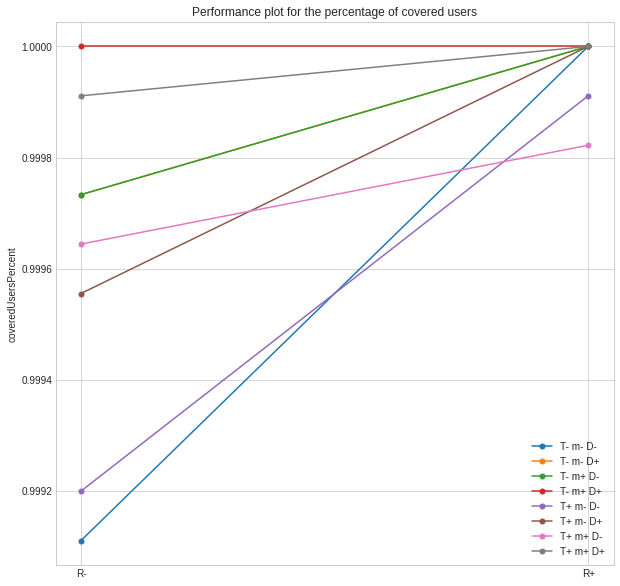

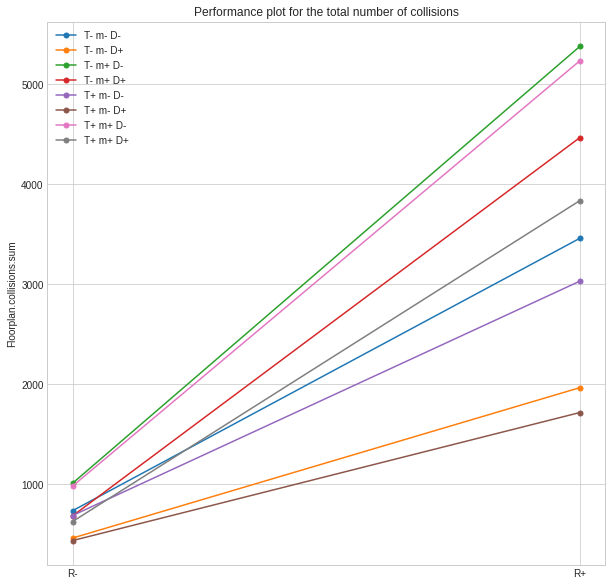

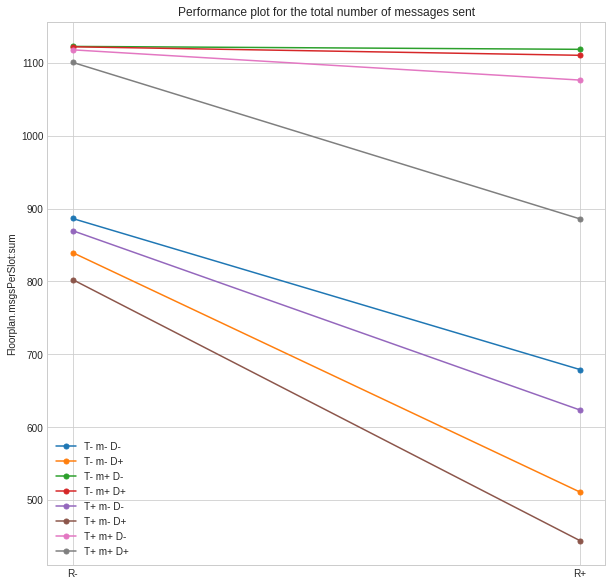

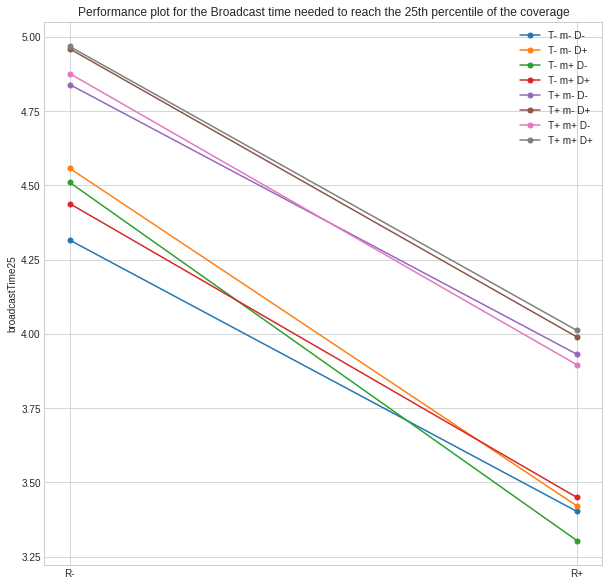

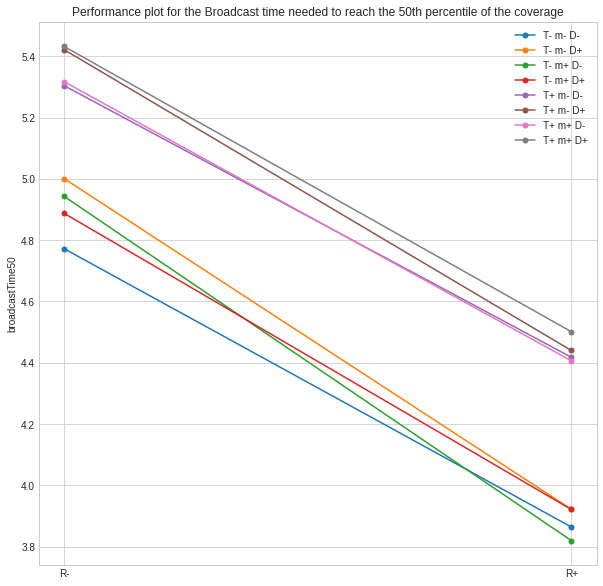

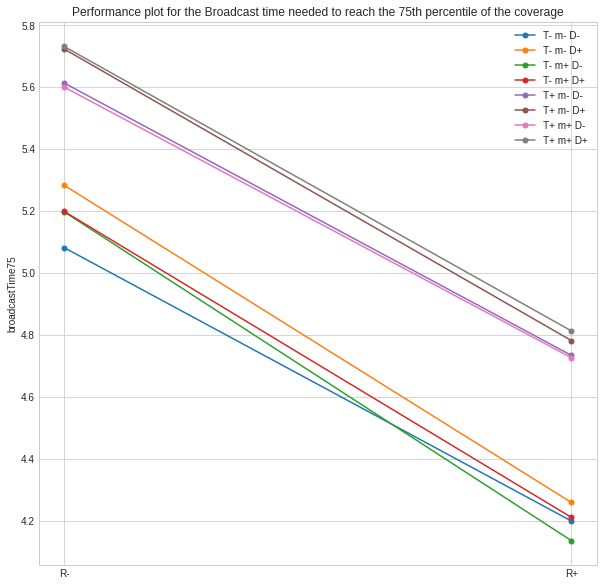

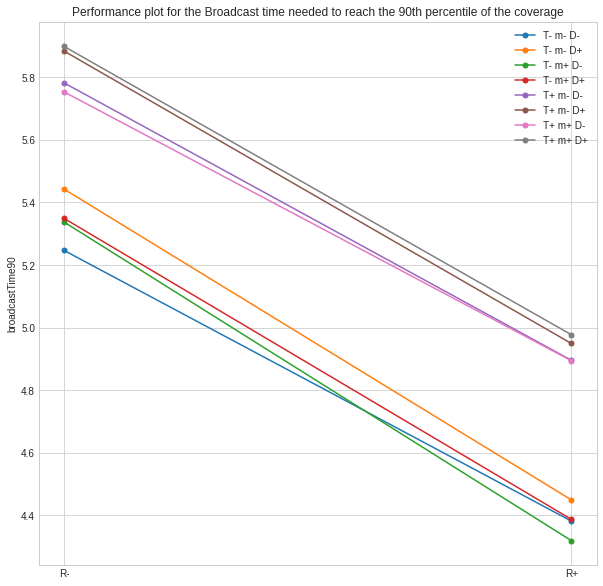

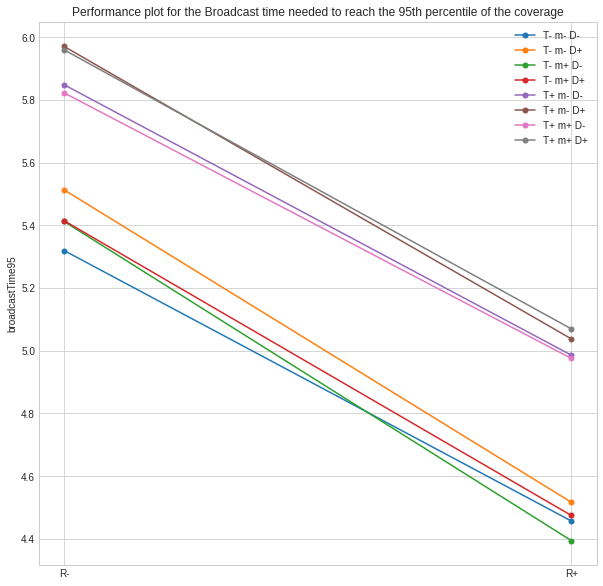

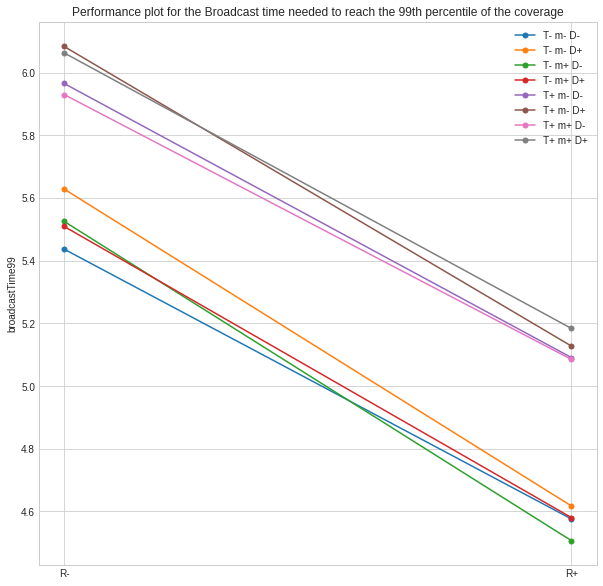

###########################

Plotting with T on the x axis...


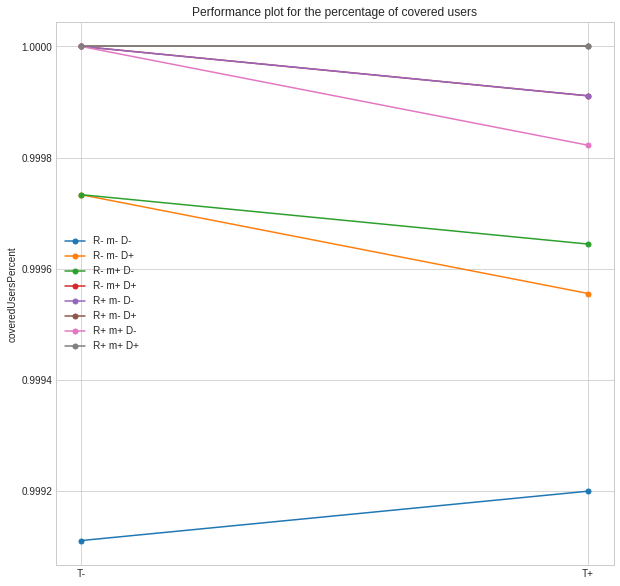

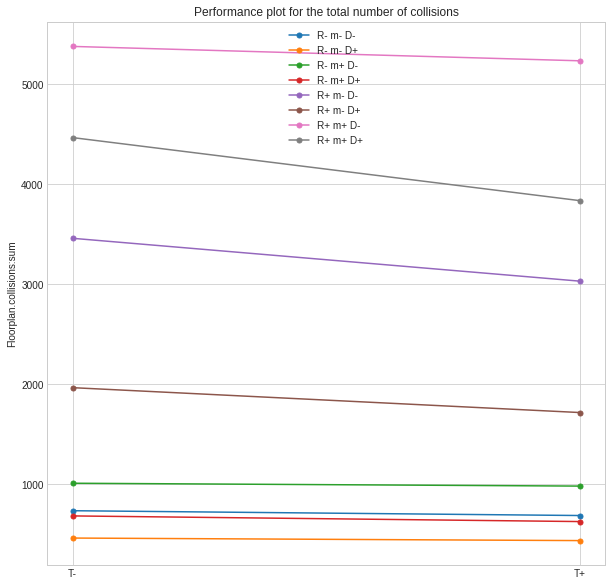

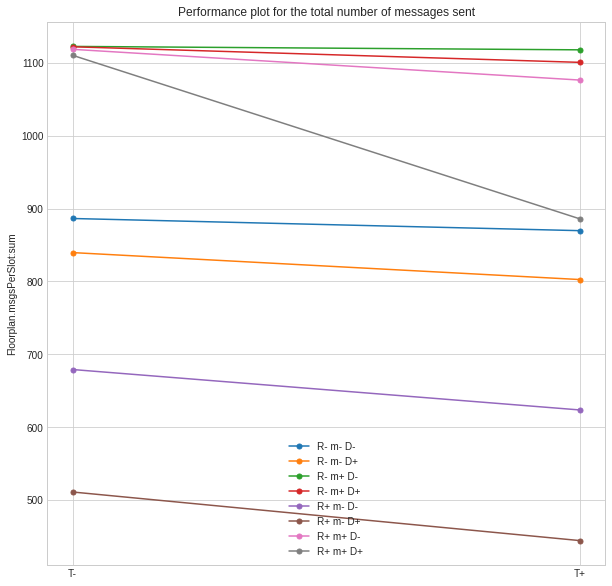

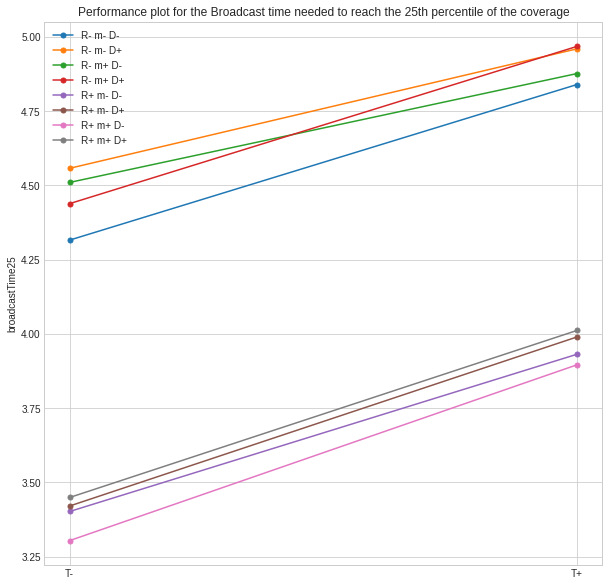

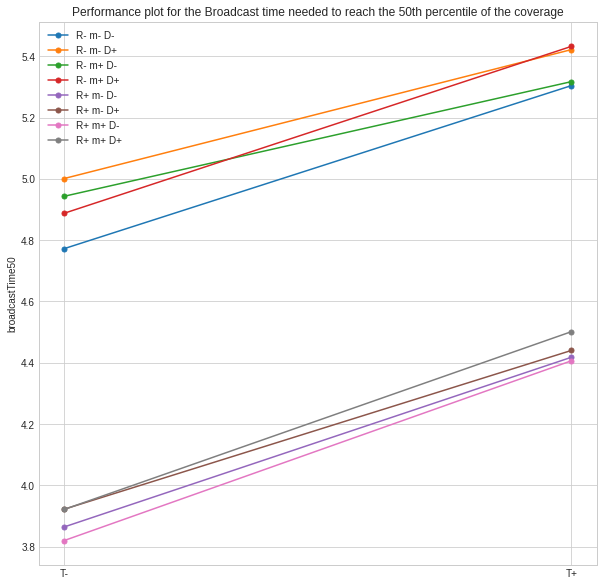

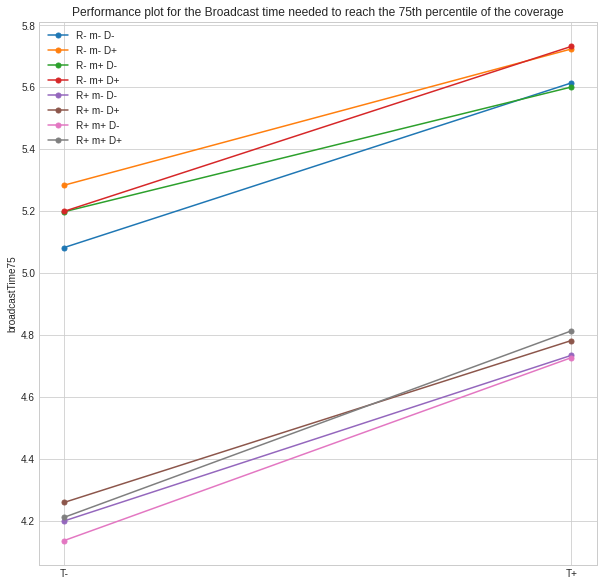

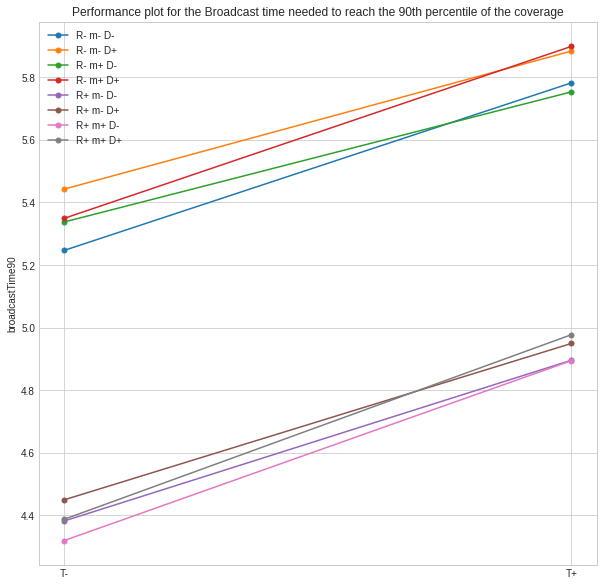

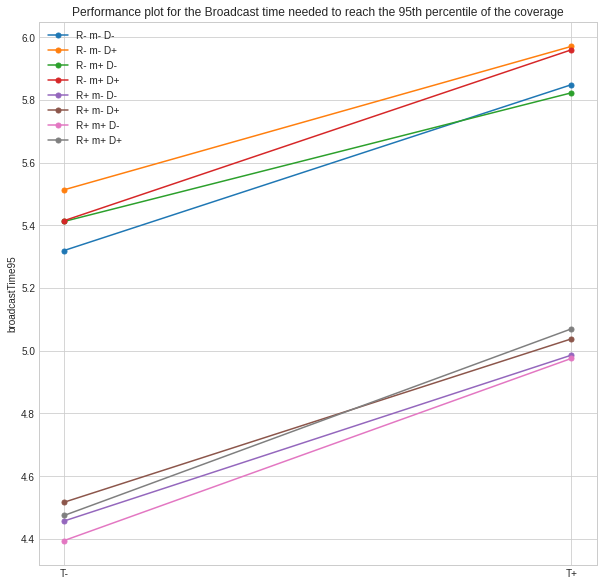

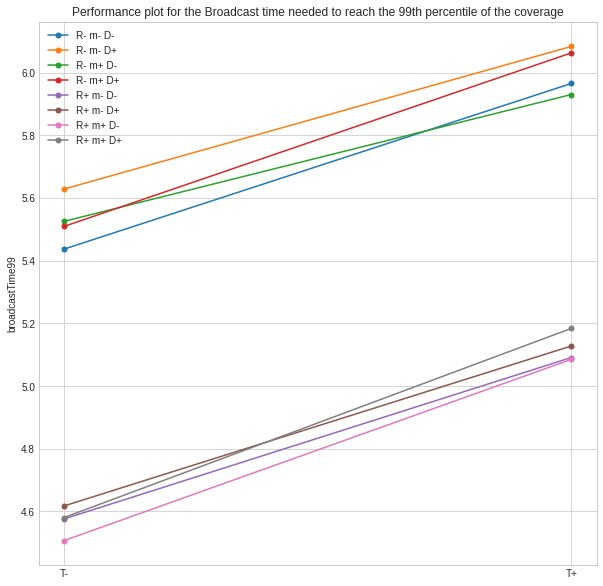

###########################

Plotting with m on the x axis...


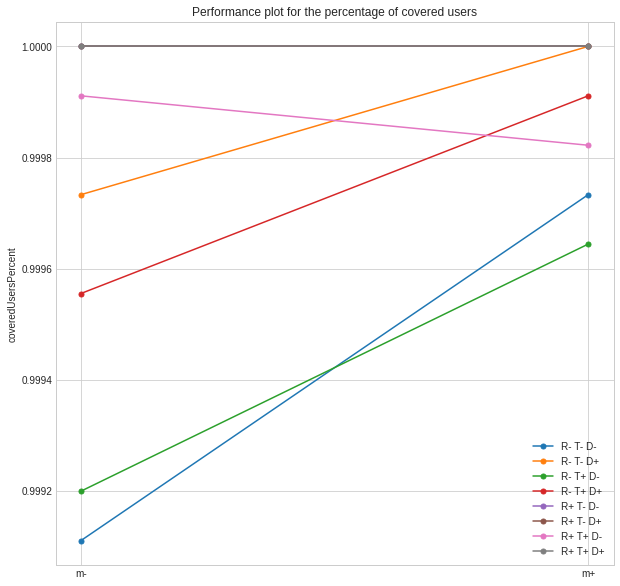

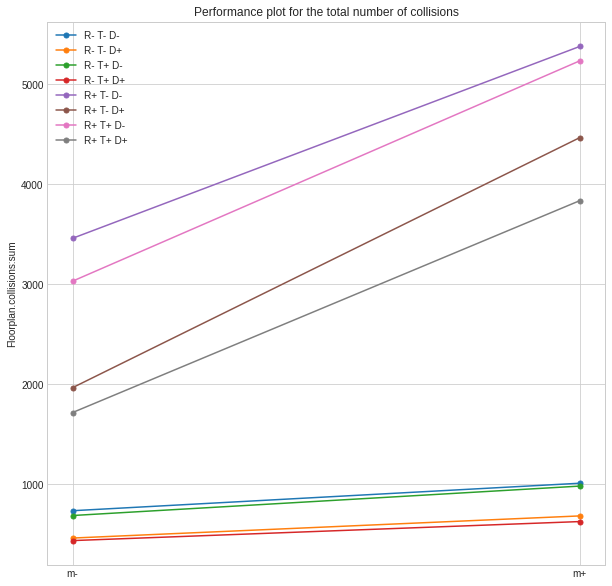

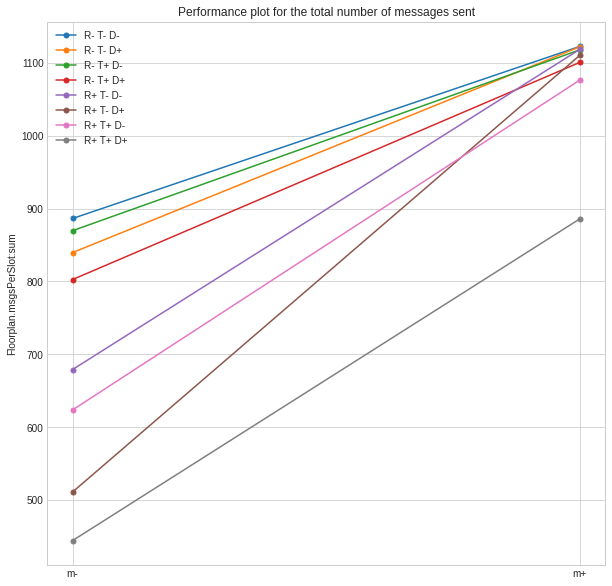

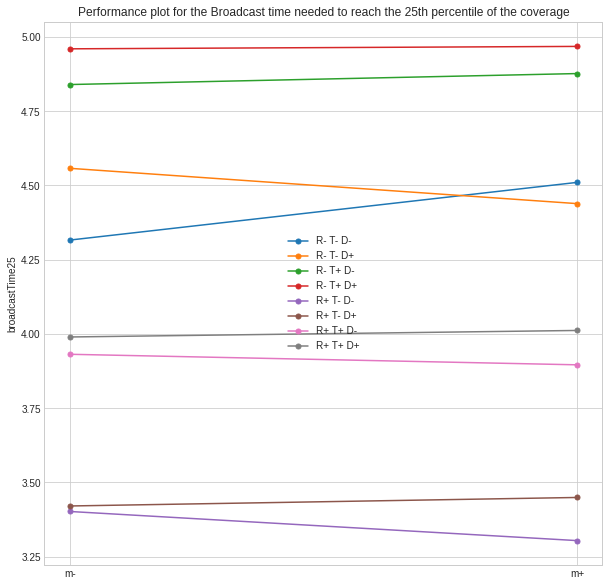

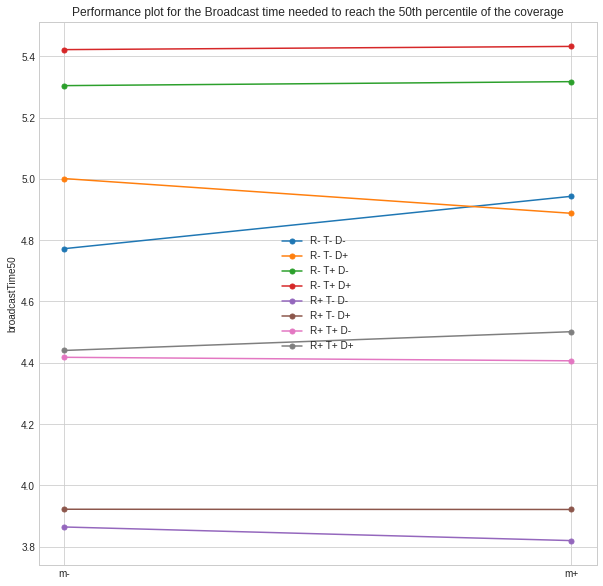

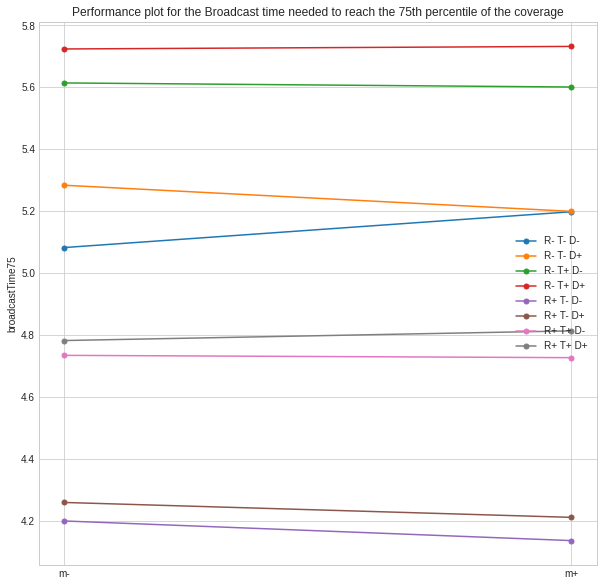

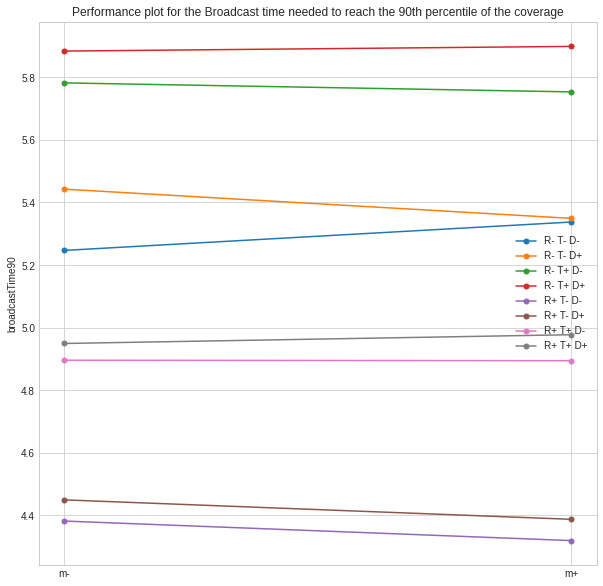

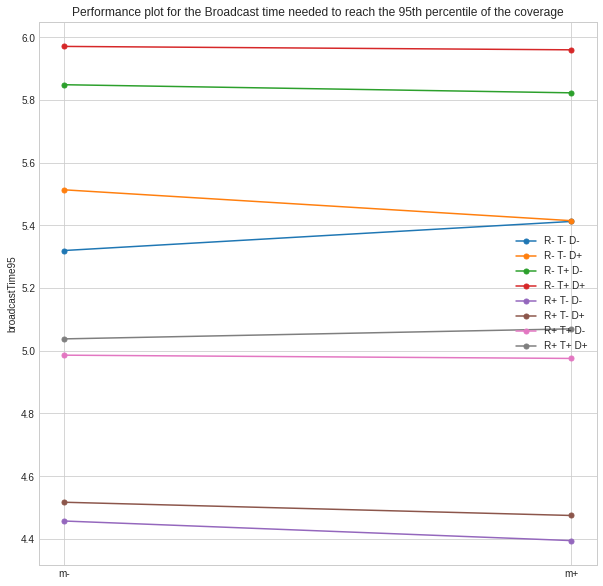

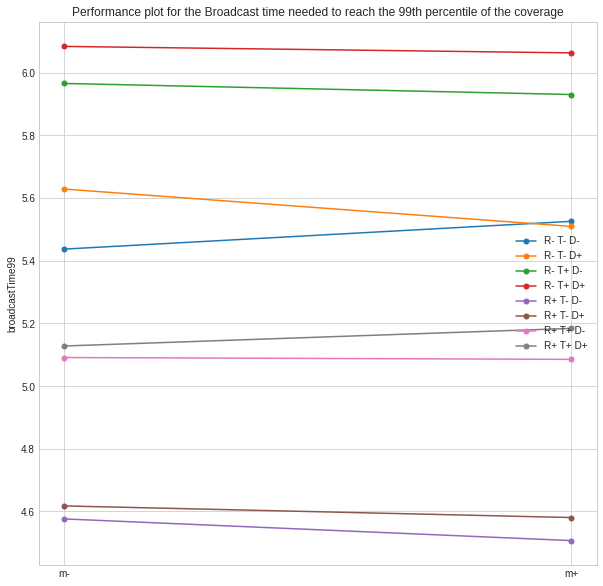

###########################

Plotting with D on the x axis...


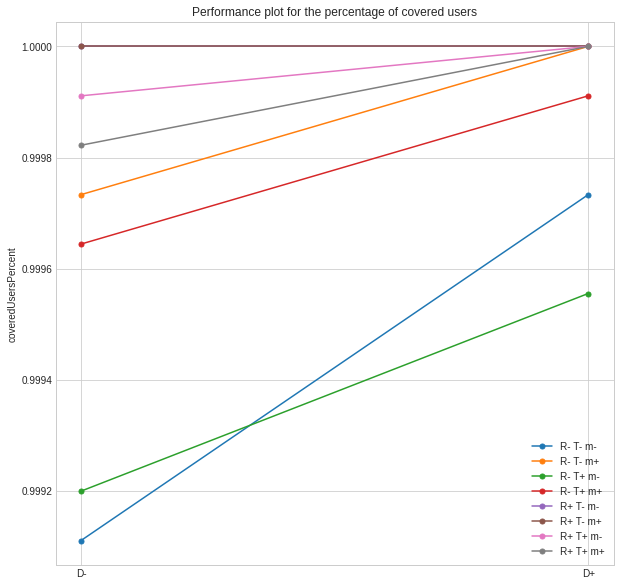

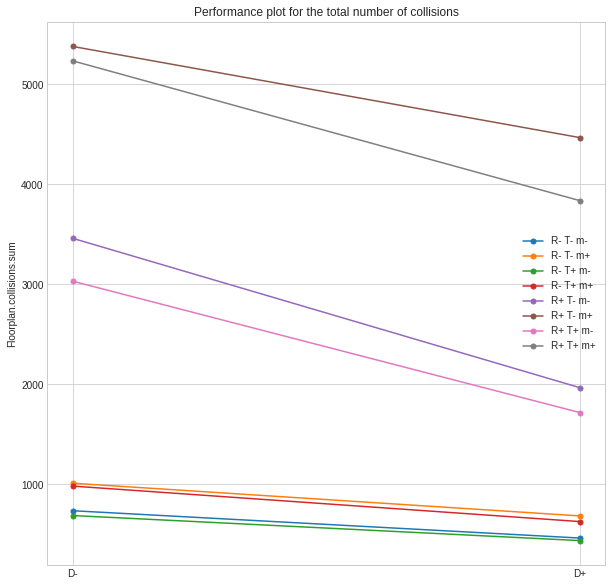

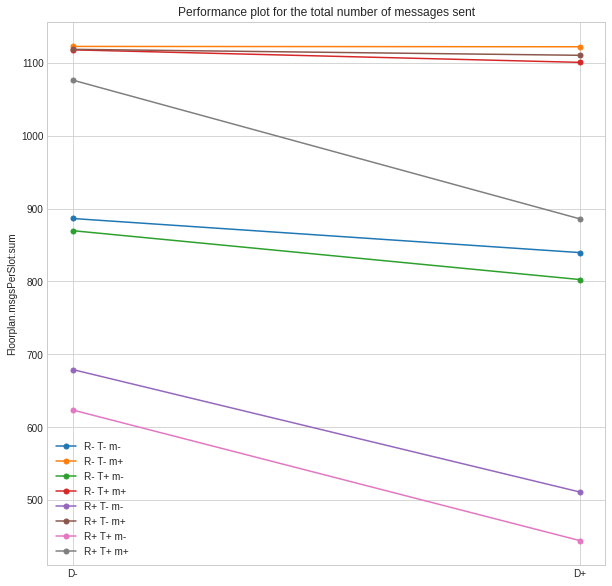

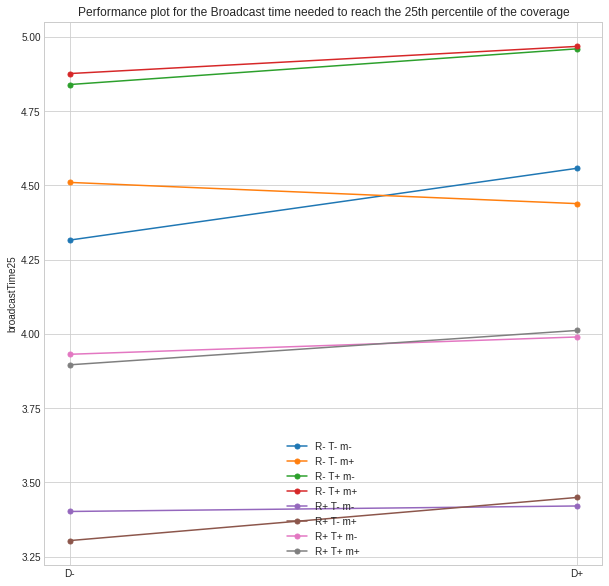

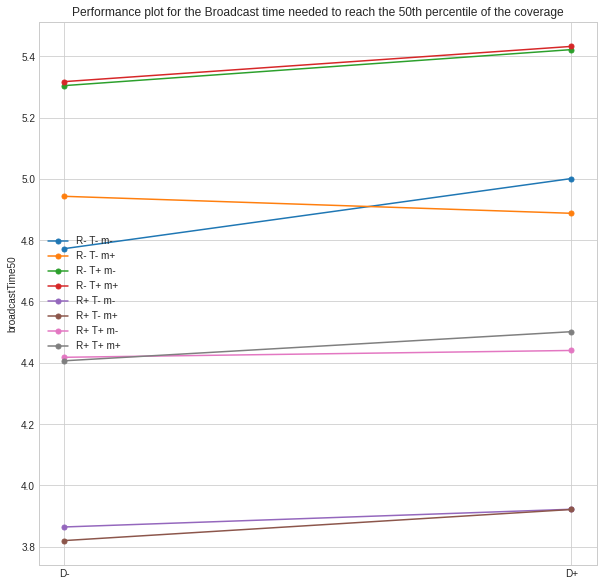

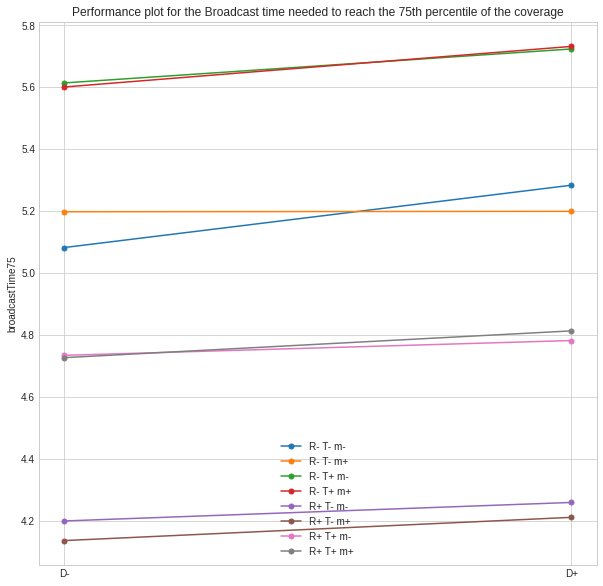

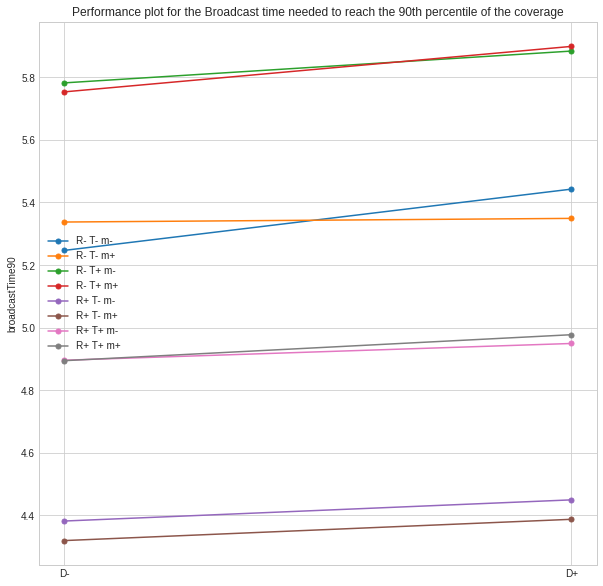

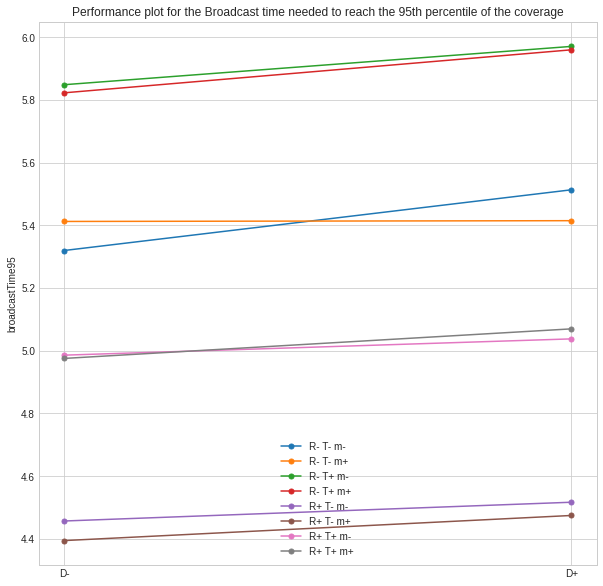

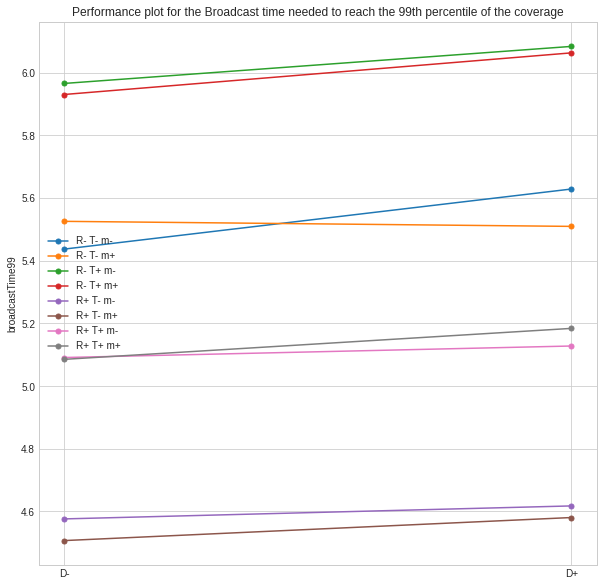

###########################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()